In [5]:
import numpy as np
from tqdm import tnrange
import chipwhisperer as cw

aes_traces_50_tracedata = np.load(r"opencl/traces/lab4_2_traces.npy")
aes_traces_50_textindata = np.load(r"opencl/traces/lab4_2_textin.npy")


trace_array = aes_traces_50_tracedata
textin_array = aes_traces_50_textindata

In [ ]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET = 'TINYAES128C'

In [ ]:
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

HW = [bin(n).count("1") for n in range(0, 256)]
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)
t_bar = np.sum(trace_array, axis=0)/len(trace_array)

o_t = np.sqrt(np.sum((trace_array - t_bar)**2, axis=0))

cparefs = [0] * 16 #put your key byte guess correlations here
bestguess = [0] * 16 #put your key byte guesses here
test = np.empty([1, ], dtype=np.float32)
for bnum in tnrange(0, 16):
    maxcpa = [0] * 256
    for kguess in range(0, 256):
        
        hws = np.array([[HW[aes_internal(textin[bnum],kguess)] for textin in textin_array]]).transpose()
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        #print("output" , hws_bar)
        correlation = cov(trace_array, t_bar, hws, hws_bar)
        cpaoutput = correlation/(o_t*o_hws)
        maxcpa[kguess] = max(abs(cpaoutput))
    bestguess[bnum] = np.argmax(maxcpa)
    cparefs[bnum] = max(maxcpa)

In [19]:
import numpy as np
import time
from tqdm import tnrange
import matplotlib.pyplot as plt

# get the start time
st = time.time()

sbox = [
     # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

HW = [bin(n).count("1") for n in range(0, 256)]

def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

# define chunk sizes
fixed_chunk_sizes = [100, 500, 1000, 2500, 5000]  # Adjust as needed

# Prepare to store chunk sizes and their respective execution times
chunk_sizes = []
execution_times = []
best_correlations = []

for chunk_size in fixed_chunk_sizes:
    print(f"Processing chunk size {chunk_size}")
    assert trace_array.shape[1] % chunk_size == 0, "The number of columns in trace_array must be divisible by the chunk size."

    trace_array_chunks = np.split(trace_array, trace_array.shape[1]//chunk_size, axis=1)

    st_chunk = time.time()

    for trace in trace_array_chunks:

        t_bar = np.sum(trace, axis=0)/len(trace_array)
        o_t = np.sqrt(np.sum((trace - t_bar)**2, axis=0))

        cparefs = [0] * 16 
        bestguess = [0] * 16 

        for bnum in range(0, 16):
            maxcpa = [0] * 256
            for kguess in range(0, 256):

                hws = np.array([[HW[aes_internal(textin[bnum],kguess)] for textin in textin_array]]).transpose()

                hws_bar = mean(hws)
                o_hws = std_dev(hws, hws_bar)

                correlation = cov(trace, t_bar, hws, hws_bar)
                cpaoutput = correlation/(o_t*o_hws)
                maxcpa[kguess] = max(abs(cpaoutput))

            bestguess[bnum] = np.argmax(maxcpa)
            cparefs[bnum] = max(maxcpa)

    et_chunk = time.time()
    elapsed_time_chunk = et_chunk - st_chunk

    execution_times.append(elapsed_time_chunk)
    chunk_sizes.append(chunk_size)
    

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Total execution time:', elapsed_time, 'seconds')



Processing chunk size 100
Processing chunk size 500
Processing chunk size 1000
Processing chunk size 2500
Processing chunk size 5000
Total execution time: 60.6615936756134 seconds


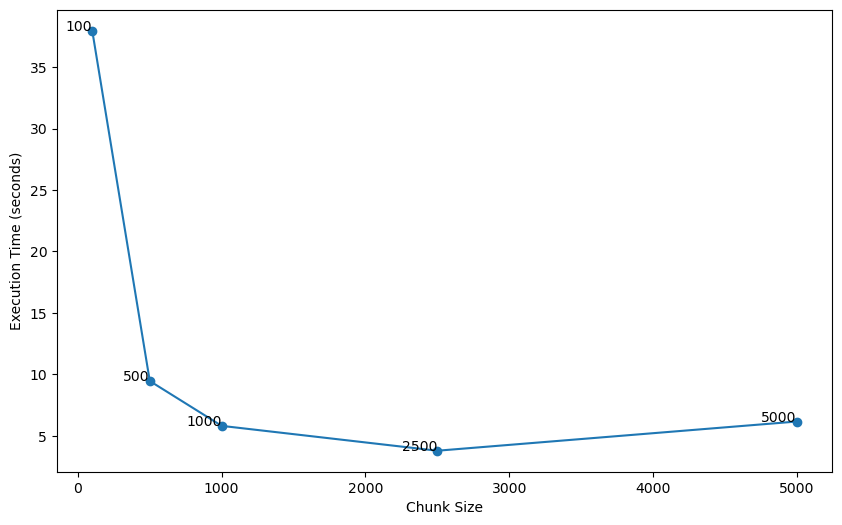

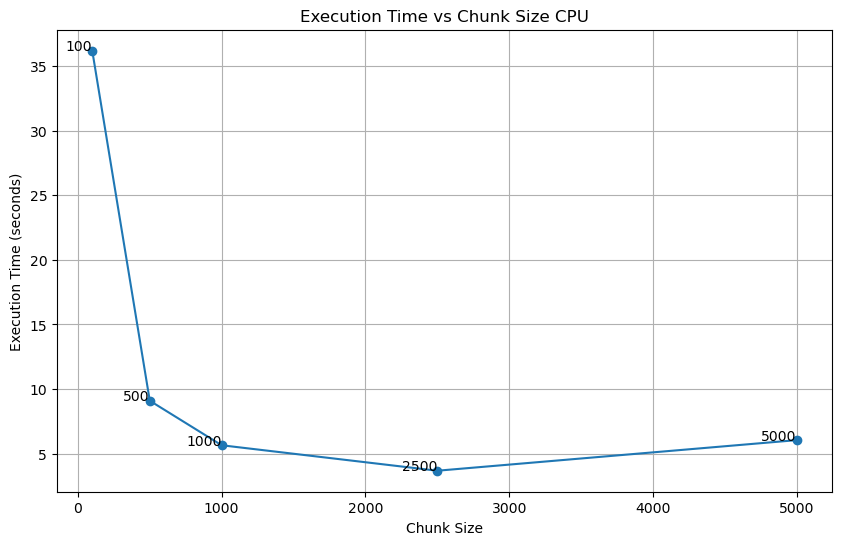

In [20]:
# Plot execution time
plt.figure(figsize=(10, 6))
plt.plot(chunk_sizes, execution_times, 'o-')
for i in range(len(chunk_sizes)):
    plt.text(chunk_sizes[i], execution_times[i], f'{chunk_sizes[i]}', ha='right')
plt.xlabel('Chunk Size')
plt.ylabel('Execution Time (seconds)')
plt.title(str('Execution Time vs Chunk Size CPU'))
plt.grid(True)
plt.savefig('Execution_Time_python_only.png', dpi=300)
plt.show()

In [ ]:
print("Best Key Guess: ", end="")
for b in bestguess: 
    print("%02x " % b, end="")
print("\n", cparefs)

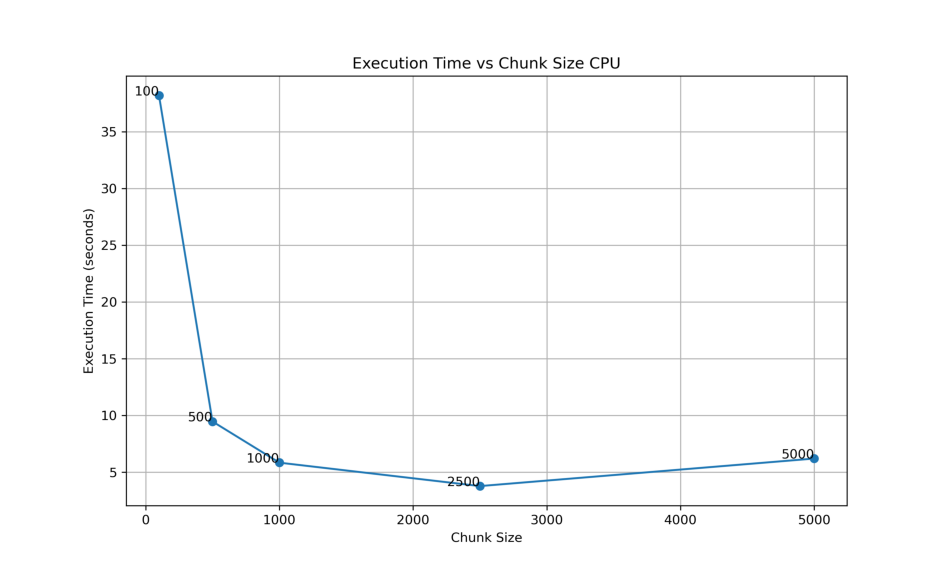

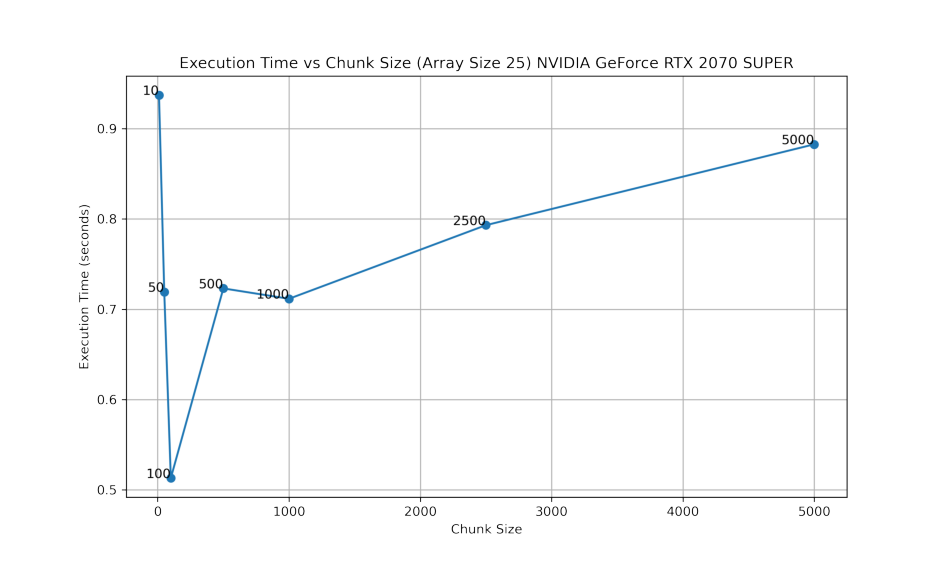

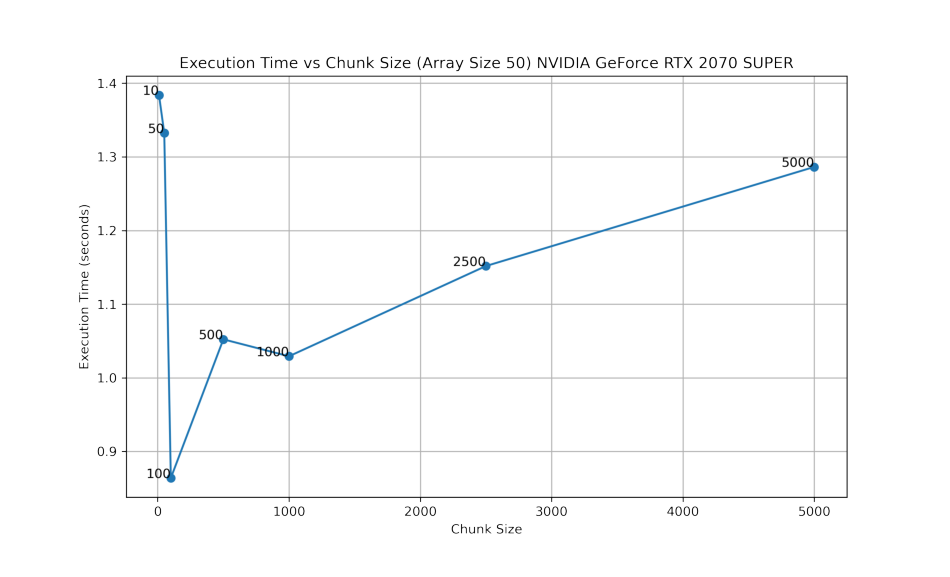

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread('Execution_Time_python_only.png')

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')  

img = mpimg.imread('Execution_Time_Array_25.png')

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')  

img = mpimg.imread('Execution_Time_Array_50.png')

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off') 
plt.show()